## Τα Στοιχεία μου
ΤΥΠΑΛΔΟΣ-ΠΑΥΛΟΣ ΑΠΟΣΤΟΛΑΤΟΣ 1115201800009



# Initialisation

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import nltk
import re
from gensim.models import Word2Vec
from sklearn.metrics import f1_score,recall_score,precision_score,confusion_matrix
from gensim.parsing.preprocessing import remove_stopwords
import urllib.request
from scipy import spatial
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
# from google.colab import drive
# drive.mount('/content/drive')
path = 'C:/Users/Pavlos/Desktop/AI2/' #update this
import sys, os
from statistics import mean

# Disable
old=sys.stdout
def blockPrint():
  sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
  sys.stdout.close()
  sys.stdout = old

print("jj")
blockPrint()
print("oo")
enablePrint()
print("uu")

jj
uu


In [16]:
train_df = pd.read_csv(path + "vaccine_train_set.csv",index_col=0)
validation_set = pd.read_csv(path + "vaccine_validation_set.csv",index_col=0) # and this. only those 2 needed to run your own test csv
print(train_df)
print(validation_set)
# print(validation_set.iat[0,0])

                                                   tweet  label
0      Sip N Shop Come thru right now #Marjais #Popul...      0
1      I don't know about you but My family and I wil...      1
2      @MSignorile Immunizations should be mandatory....      2
3      President Obama spoke in favor of vaccination ...      0
4      "@myfoxla: Arizona monitoring hundreds for mea...      0
...                                                  ...    ...
15971  @Salon if u believe the anti-vax nutcases caus...      1
15972  How do you feel about parents who don't #vacci...      0
15973  70 Preschoolers Tested for Measles in Simi Val...      0
15974  Finance Minister: Budget offers room to procur...      0
15975  Are you up to date on vaccines? Take CDC’s vac...      2

[15976 rows x 2 columns]
                                                  tweet  label
0     @user They had a massive surge in with covid d...      1
1     Required vaccines for school: Parents and guar...      0
2     “@KCStar: T

# Προεπεξεργασία δεδομένων
κανω ολες τις λεξεις lowercase ετσι ωστε να μην θεωρουνται διαφορετικες λογω ενος κεφαλαιου αρχικου γραμματος και βγαζω σημεια στιξης

In [17]:
train_df['tweet'] = train_df['tweet'].apply(lambda x: x.lower())
# train_df['tweet'] = train_df['tweet'].apply(lambda x: re.sub(r'\W', ' ', x))
# train_df['tweet'] = train_df['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))

validation_set['tweet'] = validation_set['tweet'].apply(lambda x: x.lower())
# validation_set['tweet'] = validation_set['tweet'].apply(lambda x: re.sub(r'\W', ' ', x))
# validation_set['tweet'] = validation_set['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))


In [18]:
train_df = train_df.drop(train_df[train_df.tweet.str.len() < 2].index)
validation_set = validation_set.drop(validation_set[validation_set.tweet.str.len() < 2].index)

## Αφαίρεση stopwords
i.e “a”, “the”, “is” etc

In [20]:

train_df['tweet'] = train_df['tweet'].apply(lambda x: remove_stopwords(x))
validation_set['tweet'] = validation_set['tweet'].apply(lambda x: remove_stopwords(x))


# Οπτικοποίηση Δεδομένων

In [21]:
print("test set Examples:")
pd.DataFrame(train_df['tweet']).head(10)

test set Examples:


,tweet
0,sip n shop come right #marjais #popularnobodie...
1,don't know family #covid19 vaccine anytime soo...
2,@msignorile immunizations mandatory. period. o...
3,president obama spoke favor vaccination childr...
4,"""@myfoxla: arizona monitoring hundreds measles..."
5,whooping cough vaccine day bring baby home? ca...
6,prosecutor ken ervin: want know recklessly kil...
7,"""@uberfacts: average, people complain live lon..."
8,legacy @jennymccarthy took clothes $$ contribu...
9,"“@uberfacts: average, people complain live lon..."


In [22]:
print("validation set Examples:")
pd.DataFrame(validation_set['tweet']).head(10)
# values, counts = np.unique(validation_set['label'], return_counts=True)
# print(values, counts )

validation set Examples:


,tweet
0,@user massive surge covid deaths immediately v...
1,required vaccines school: parents guardians ch...
2,“@kcstar: johnson county children measles http...
3,nv better. states best (and worst) vaccinating...
4,like killing w/ fear mt@alyssa_milano: vaccine...
5,"i'm subscribing panic du jour. it's measles, r..."
6,@801punx fav songs check aptbs = exploding hea...
7,happend covid-19 vaccine test candidates died ...
8,zenith #bs --&gt;&gt; cdc says ebola vaccine w...
9,@dlockyer second occurrence read vaccines harm...


1.glove or w2v
2.activation function softmax relu
optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
3. optimiser aka solver SGD Adam
4. loss function MSELoss CrossEntropyLoss
5.

##Optimisation των λεξεων μας για το Twitter
οι λεξεις του twitter εχουν διαφορες ιδιαιτεροτητες οπως emojies hashtags user tags κλπ. αυτο το script που συνισταται απο την ιστοσελίδα του glover μας επιτρεπει να αναγνωριζουμε αυτα τα χαρακτηριστικα στις λεξεις των αρχειων μας και να συνυπολογίζουμε την σημασία τους στα vector της καθε λεξης.

η μέθοδος ειναι οτι οταν ανιχνευσει ενα χαρακτηριστικο προσθετει στην προταση την λεξη <χαρακτηριστικο> η οποία υπάρχει στο vocabulary txt αρχειο και μας δινει ένα εκπαιδευμένο vector

πχ τα allcaps συχνά δείχνουν θυμό και αρνητικότητα(μήπως θα μας ωθήσει σε anti-vax πρόβλεψη??)

In [25]:
"""
preprocess-twitter.py

python preprocess-twitter.py "Some random text with #hashtags, @mentions and http://t.co/kdjfkdjf (links). :)"

Script for preprocessing tweets by Romain Paulus
with small modifications by Jeffrey Pennington
with translation to Python by Motoki Wu (github.com/tokestermw)

Translation of Ruby script to create features for GloVe vectors for Twitter data.
http://nlp.stanford.edu/projects/glove/preprocess-twitter.rb

this version from gist.github.com/ppope > preprocess_twitter.py

light edits by amackcrane, mostly inspired by the test case given at bottom
"""

import sys
import regex as re

FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps> " # amackcrane added trailing space


def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\w+", hashtag)  # amackcrane edit
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")
    

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    #text = re_sub(r"([A-Z]){2,}", allcaps)  # moved below -amackcrane

    # amackcrane additions
    text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
    text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
    text = re_sub(r"  ", r" ")
    text = re_sub(r" ([A-Z]){2,} ", allcaps)
    
    return text.lower()

if __name__ == '__main__':
    #_, text = sys.argv  # kaggle envt breaks this -amackcrane
    #if text == "test":
    text = "I TEST alllll kinds of #hashtags and #HASHTAGS, @mentions and 3000 (http://t.co/dkfjkdf). w/ <3 :) haha!!!!!"
    text2 = "TEStiNg some *tough* #CASES" # couple extra tests -amackcrane
    tokens = tokenize(text)
    print(tokens)
    print(tokenize(text2))


i test  <allcaps> al <elong> kinds of <hashtag> hashtags and <hashtag> hashtags <allcaps> , <user> and <number> ( <url> ) . w / <heart> <smile> haha ! <repeat>
testing some *tough* <hashtag> cases <allcaps>


# Classification

##Confusion Matrix

ιδια υλοποίση με αυτη τη στην εργασία 1

In [26]:
def ConfusionMatrix(test_label,ypred):
  C = confusion_matrix(test_label,ypred)
  confusionMatrix = pd.DataFrame(data = C, index=['neutral(0), true','anti-vax(1), true','pro-vax(2), true'], columns = ['neutral(0), predicted','anti-vax(1), predicted','pro-vax(2), predicted'])
  confusionMatrix.loc['sum'] = confusionMatrix.sum()
  confusionMatrix['sum'] = confusionMatrix.sum(axis=1)
  print(confusionMatrix.to_string())
  confMx = confusionMatrix.values[0:3,0:3]
  plt.matshow(confMx, cmap=plt.cm.gray)
  plt.show()



##SoftMax
ιδια υλοποίση με αυτη τη στην εργασία 1

In [27]:
def MySoftMax():
  test_result = 0.0
  train_result = 0.0
  SoftMax=LogisticRegression(multi_class = 'multinomial',solver = 'lbfgs',max_iter=1000)
  SoftMax.fit(traindata,trainlabel) #execute each clustering method
  accuracy = SoftMax.score(testdata, testlabel) # grade how much the content of the test text set,based on the training, corresponds it's true label
  y_pred=SoftMax.predict(testdata) # experimentaly predict the label based on our training and compare it to the true label
  print("SoftMax")
  print("accuracy = ", accuracy * 100, "%")
  # learn_rate[0]+=f1_score(testlabel,y_pred,average='macro' ) * 100
  for metric,metric_name in zip([f1_score(testlabel,y_pred,average='macro' ) * 100,recall_score(testlabel,y_pred,average='macro' ) * 100,precision_score(testlabel,y_pred,average='macro',zero_division=0) * 100], ["F measure =","recall score =","precision score ="]):#ngram_range has varying result
    print(metric_name,metric , "%")
    test_result+=metric
  test_results.append(test_result/3)#keep the mean of the metrics for Learning Curve plotting
  ConfusionMatrix(testlabel,y_pred);
  print("ON TRAINING DATA = ")
  accuracy = SoftMax.score(traindata, trainlabel)
  print("accuracy on training data = ", accuracy * 100, "%")
  y_pred=SoftMax.predict(traindata) 
  # learn_rate[1]+=f1_score(trainlabel,y_pred,average='macro' ) * 100
  for metric,metric_name in zip([f1_score(trainlabel,y_pred,average='macro' ) * 100,recall_score(trainlabel,y_pred,average='macro' ) * 100,precision_score(trainlabel,y_pred,average='macro',zero_division=0) * 100], ["F measure =","recall score =","precision score ="]):#ngram_range has varying result
    print(metric_name,metric , "%")
    train_result+=metric
  train_results.append(train_result/3)
  ConfusionMatrix(trainlabel,y_pred);

##Neural Networks


In [ ]:
def Classiefiers():
  test_result = 0.0
  train_result = 0.0
  SoftMax=LogisticRegression(multi_class = 'multinomial',solver = 'lbfgs',max_iter=1000)
  for classifierName, neuralNetwork in zip(["MLPClassifier","MLPClassifier with sgd and sigmoid logistic activation"],[MLPClassifier(hidden_layer_sizes=100, activation='relu', solver='adam', batch_size='auto',max_iter=1000),MLPClassifier(hidden_layer_sizes=100, activation='logistic', solver='sgd', batch_size='auto',max_iter=1000)]):
    neuralNetwork.fit(traindata,trainlabel) #execute each clustering method
    accuracy = neuralNetwork.score(testdata, testlabel) # grade how much the content of the test text set,based on the training, corresponds it's true label
    y_pred=neuralNetwork.predict(testdata) # experimentaly predict the label based on our training and compare it to the true label
    print(classifierName)
    print(neuralNetwork.loss_)
    print(neuralNetwork.loss_curve_)
    print(len(neuralNetwork.loss_curve_))
    print("accuracy = ", accuracy * 100, "%")
    # learn_rate[0]+=f1_score(testlabel,y_pred,average='macro' ) * 100
    for metric,metric_name in zip([f1_score(testlabel,y_pred,average='macro' ) * 100,recall_score(testlabel,y_pred,average='macro' ) * 100,precision_score(testlabel,y_pred,average='macro',zero_division=0) * 100], ["F measure =","recall score =","precision score ="]):#ngram_range has varying result
      print(metric_name,metric , "%")
      test_result+=metric
    ConfusionMatrix(testlabel,y_pred);
    print("ON TRAINING DATA = ")
    accuracy = neuralNetwork.score(traindata, trainlabel)
    print("accuracy on training data = ", accuracy * 100, "%")
    y_pred=neuralNetwork.predict(traindata) 
    # learn_rate[1]+=f1_score(trainlabel,y_pred,average='macro' ) * 100
    for metric,metric_name in zip([f1_score(trainlabel,y_pred,average='macro' ) * 100,recall_score(trainlabel,y_pred,average='macro' ) * 100,precision_score(trainlabel,y_pred,average='macro',zero_division=0) * 100], ["F measure =","recall score =","precision score ="]):#ngram_range has varying result
      print(metric_name,metric , "%")
      train_result+=metric
    ConfusionMatrix(trainlabel,y_pred);
  test_results.append(test_result/6)#keep the mean of the metrics for Learning Curve plotting
  train_results.append(train_result/6)


#Φόρτωση GloVe λεξιλογείου Twitter

χρησιμοποίω το μεγαλύτερο txt λεξιλογείου για μεγαλύτερη ακρίβεια. αν δεν ειναι η πρώτη φορα που τρέχετε το notebook παραλείπτε αυτο το βημα γιατι απλ κατεβαζει το αρχειο.

αν θέλετε το αρχείο να κατεβει καπου αλλου και οχι στο path που ειναι τα csv αλλαχτε το $path πχ
!unzip "/content/glove.6B.zip" -d "/content/"


In [ ]:
urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.twitter.27B.zip','glove.27B.zip') #i load the largest vocabulary for the most accuracy
!unzip "/content/glove.27B.zip" -d $path


Archive:  /content/glove.27B.zip
  inflating: /content/drive/MyDrive/AI2/glove.twitter.27B.25d.txt  
  inflating: /content/drive/MyDrive/AI2/glove.twitter.27B.50d.txt  
  inflating: /content/drive/MyDrive/AI2/glove.twitter.27B.100d.txt  
  inflating: /content/drive/MyDrive/AI2/glove.twitter.27B.200d.txt  


αντιστοιχώ κάθε λεξη με εναν vector. ουσιαστικά μεταφόρα απο αρχείο txt σε μνήμη

In [30]:
emmbed_dict = {}
d=200
with open(path + 'glove.twitter.27B.' + str(d) + 'd.txt','r', encoding="utf8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector

In [31]:
def find_similar_word(emmbedes):
  nearest = sorted(emmbed_dict.keys(), key=lambda word: spatial.distance.euclidean(emmbed_dict[word], emmbedes))
  return nearest
emmbed_dict.get("river", 0.000)
# np.zeros((200,), dtype=float)

array([-7.3568e-01, -1.7927e-01,  1.8122e-01, -1.1934e-01,  5.3740e-01,
        7.2252e-01,  2.6753e-01,  6.2066e-01, -4.8098e-01, -4.2978e-01,
        1.5315e-01,  5.4204e-01, -1.2235e-01,  5.0970e-01, -2.3353e-02,
        4.3671e-01,  5.0077e-01,  5.4246e-02,  7.1848e-01, -7.7348e-01,
        2.7460e-01, -4.3988e-01,  1.6898e-01, -3.0886e-01, -2.2642e-01,
       -1.2224e+00, -5.5304e-01,  8.4110e-02, -2.6801e-01, -3.7397e-01,
       -2.3221e-01,  3.2264e-01,  5.0858e-01,  2.3427e-01,  1.6964e-01,
       -2.1864e-01,  9.1073e-02,  5.3864e-01,  5.8349e-01, -3.1867e-01,
        2.7548e-01,  1.4245e-01, -3.1331e-01, -5.9183e-02,  1.0183e-01,
        2.3288e-02, -1.9689e-01,  3.1934e-01,  3.6827e-01,  4.1610e-01,
       -1.7543e-01, -5.7951e-02,  1.6626e-01,  1.6511e-01,  1.0885e-01,
       -1.8602e-01, -6.1585e-01,  2.9076e-01,  2.3026e-02,  2.9966e-01,
       -7.7732e-01,  9.3240e-01, -6.9943e-02, -1.2402e-01,  9.1285e-01,
        1.4358e-01, -5.6668e-01, -3.8502e-01, -2.8998e-01, -3.88

# Classification with Word2Vec & GloVe
το GloVe εχει έτοιμο λεξιλόγιο και vectors για αυτο ενω το Word2Vec τα παράγει απο τα csv δεδόμενων μας.

στο glove οταν δεν υπάρχει μια λεξη στο λεξιλόγιο βαζω της αναθέτω εναν μηδενικο vector για να μην έχει αντίκτυπο στο classification

μια προταση πρεπει να εχει ενα 1xN πινακα οπου N=200 για το GloVe και 100 γία το Word2Vec. μια προτααση εχει πολλες λεξεις που γυρνανε  1xN vector φτιαχνοντας εναν MxN πίνακα. για να τον κάνω 1xN παίρω τον μέσο ορο των M γραμμων

#ΠΑΡΑΔΟΧΗ:
στο Word2Vec δεν μπορεσα να σχεδιασω learning curve λογω περιορισμου RAM και runtime

In [32]:
trainlabel = torch.tensor(train_df['label'])#extract true-false label
testlabel=torch.tensor(validation_set['label'])
sentences = pd.concat([train_df.tweet,validation_set.tweet],ignore_index=True)
nltk.download('punkt')
# simple tokenization
tokens = [nltk.word_tokenize(sentence) for sentence in sentences]

w2vmodel = Word2Vec(tokens,
                    seed=32,
                    negative=5,
                    sg=0,
                    min_count=1,
                    window=1)

w2vmodel.build_vocab(tokens, update=True)  # prepare the model vocabulary
w2vmodel.train(tokens, total_examples=len(tokens), epochs=2)
train_tokens = [nltk.word_tokenize(sentences) for sentences in train_df.tweet ]
test_tokens = [nltk.word_tokenize(sentences) for sentences in validation_set.tweet]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pavlos\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [33]:
test_result = 0.0
train_result = 0.0
test_results = []
train_results = []
test_learning_curve = []
train_learning_curve = []
print("Word2Vec")
w2v_traindata = torch.tensor( [np.array([w2vmodel.wv.get_vector(word) for word in record]).mean(axis=0) for record in train_tokens], dtype=torch.float)
w2v_testdata = torch.tensor([np.array([w2vmodel.wv.get_vector(word) for word in record]).mean(axis=0) for record in test_tokens], dtype=torch.float)
# print(traindata)

# Classiefiers()#this arguement doesnt matter here

print()

print("Glove")
glv_traindata = torch.tensor([np.array([emmbed_dict.get(tokenize(word),np.zeros((200,), dtype=float)) for word in record]).mean(axis=0) for record in train_tokens], dtype=torch.float)
glv_testdata = torch.tensor([np.array([emmbed_dict.get(tokenize(word),np.zeros((200,), dtype=float)) for word in record]).mean(axis=0) for record in test_tokens], dtype=torch.float)
# Classiefiers()#this arguement doesnt matter here
# print(traindata)


Word2Vec


C:\Users\Pavlos\AppData\Local\Temp/ipykernel_9656/3922157312.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  w2v_traindata = torch.tensor( [np.array([w2vmodel.wv.get_vector(word) for word in record]).mean(axis=0) for record in train_tokens], dtype=torch.float)



Glove


In [34]:
torch.cuda.is_available()

True

In [37]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
      
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
# train_loader = DeviceDataLoader(train_loader, device)
# val_loader = DeviceDataLoader(val_loader, device)
device = get_default_device()

[tensor([[ 0.7083, -0.0651,  0.4189,  ...,  0.4145,  0.2289,  0.5448],
        [ 0.8633, -0.2008,  0.2664,  ...,  0.2888,  0.3035,  0.4223],
        [ 0.8902, -0.1297,  0.3373,  ...,  0.3536,  0.4559,  0.3584],
        ...,
        [ 0.5227, -0.1880,  0.2008,  ..., -0.0907, -0.1667,  0.4863],
        [ 1.2452, -0.2654,  0.1805,  ...,  0.3536,  0.0521,  0.3351],
        [ 0.8406, -0.1156,  0.4465,  ...,  0.4758,  0.1957,  0.4426]],
       device='cuda:0'), tensor([2, 0, 0, 1, 2, 2, 0, 1, 0, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2,
        1, 0, 2, 1, 2, 0, 2, 2, 0, 2, 2, 1, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 1, 2,
        2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0], device='cuda:0')]
100
21.122199818287775
21.115132971882215
[tensor([[ 0.1564, -0.1301, -0.0298,  ...,  0.0818,  0.1664,  0.2724],
        [ 0.0276, -0.1211, -0.1823,  ...,  0.1212, -0.1961,  0.0348],
        [ 0.1269, -0.1761, -0.0244,  ..., -0.1607,  0.0444,  0.0694],
        ...,
        [ 0.0836,  0.0383, -0.0518,  ..

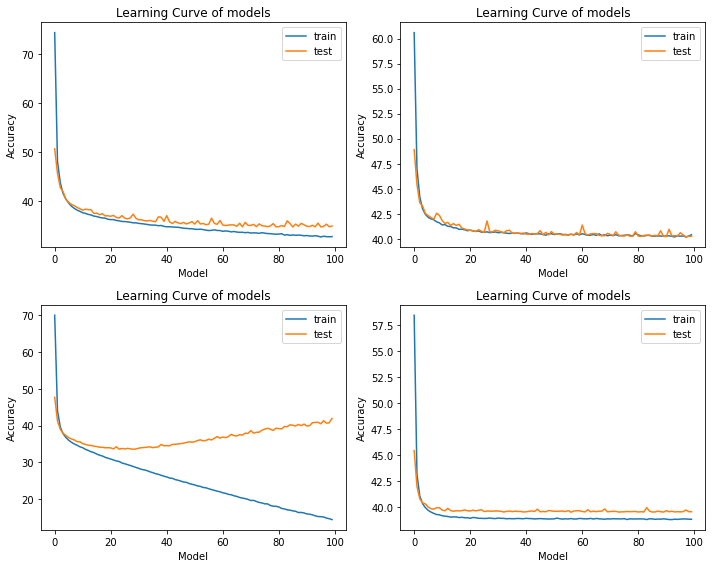

In [58]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(D_in, H1),
            nn.ReLU(),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Linear(H3, D_out),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
class Net2(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net2, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        
    def forward(self, x):
        h1 = self.linear1(x)
        h2 = self.linear2(h1)
        h3 = self.linear3(h2)
        out = self.linear4(h3)
        return out
class Net3(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(D_in, H1,1)
        self.conv2 = nn.Conv2d(H1, H2, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(H2, H3)
        self.fc2 = nn.Linear(H3, D_out)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

#Initialize dataloader
# plt.subplot(2,2,1)
fig, ax = plt.subplots(2,2)
k=0
for embd,(traindata,testdata) in  enumerate(zip([w2v_traindata,glv_traindata],[w2v_testdata,glv_testdata])):
  to_device(traindata,device)
  to_device(testdata,device)
  trainset = torch.utils.data.TensorDataset(traindata, trainlabel)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
  trainloader = DeviceDataLoader(trainloader, device)
  for data in trainloader:
    print (data)
    break
  testset = torch.utils.data.TensorDataset(testdata, testlabel)
  testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
  testloader = DeviceDataLoader(testloader, device)
  D_in = traindata.shape[1]
  print(D_in)
  H1 = 128
  H2 = 64
  H3 = 32
  D_out = 1

  #Define Hyperparameters
  learning_rate = 1e-4
  #Initialize model, loss, optimizer
  for i , model in enumerate([Net(D_in, H1, H2, H3, D_out),Net2(D_in, H1, H2, H3, D_out)]):
    to_device(model,device)
    for j, (loss_func,optimizer) in enumerate(zip([nn.MSELoss(reduction='sum')],[torch.optim.Adam(model.parameters(), lr=learning_rate)])):
      train_losses=[]
      test_losses=[]
      model.train()
      for epoch in range(100):
        batch_losses = []
        for x_batch, y_batch in trainloader:
          output = model(x_batch)
          # print(x_batch.shape[0])
          # print(y_batch)
          pred_probab = nn.Softmax(dim=1)(output)
          y_pred = pred_probab.argmax(1)
          # print(y_pred)
          # print((f1_score(y_batch,y_pred,average='macro' ) * 100))
          loss = loss_func(output.view(y_batch.shape[0]).float(), y_batch.float())
          batch_losses.append(loss.item())
          
          #Delete previously stored gradients
          optimizer.zero_grad()
          #Perform backpropagation starting from the loss calculated in this epoch
          loss.backward()
          #Update model's weights based on the gradients calculated during backprop
          optimizer.step()
        
        # print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainloader):.5f}")
        train_losses.append(sum(batch_losses)/len(trainloader))
        model.eval()
        scores=[]
        batch_losses = []
        for x_batch, y_batch in testloader:
          output = model(x_batch)
          # print(x_batch.shape[0])
          # print(y_batch)
          pred_probab = nn.Softmax(dim=1)(output)
          y_pred = pred_probab.argmax(1)
          loss = loss_func(output.view(y_batch.shape[0]).float(), y_batch.float())
          batch_losses.append(loss.item())
          # print(y_pred)
          scores.append(f1_score(y_batch.cpu(),y_pred.cpu(),average='macro' ) * 100)
        test_losses.append(sum(batch_losses)/len(testloader))
      # print(train_losses)
      # print(test_losses)
      print(mean(scores))
      k=k+1
      # plt.subplot(2, 2, k)
      # plt.figure(κ)
      ax[embd][i].plot(range(100), train_losses)
      ax[embd][i].plot(range(100), test_losses)
      ax[embd][i].legend(['train', 'test'])
      ax[embd][i].set_xlabel("Model")
      ax[embd][i].set_ylabel("Accuracy")
      ax[embd][i].title.set_text("Learning Curve of models")
fig.set_figwidth(10)
fig.set_figheight(4*2)
plt.tight_layout()
plt.show()

In [ ]:
plt.show()

In [ ]:
model.eval()
from statistics import mean
scores=[]
for x_batch, y_batch in testloader:
  output = model(x_batch)
  # print(x_batch.shape[0])
  # print(y_batch)
  pred_probab = nn.Softmax(dim=1)(output)
  y_pred = pred_probab.argmax(1)
  # print(y_pred)
  scores.append(f1_score(y_batch,y_pred,average='macro' ) * 100)
print(mean(scores))

21.101872032841097


#Συμπερασματα(προσωρινα)
τα μοντελα μου εχουν μια ελαφρη κλιση προς το neutral και εχουν τρομερο προβλημα στο να ανιχνευουν anti-vax tweets και απο εκει προερχονται τα χαμηλα ποσοστα ακριβειασ μου. αν μπορουσα να  φτιαξω το anti-vax μια 33% αυξηση των ποσοστων θα ηταν πολυ καλη 

ετρεξα τους vectorizers με μονο bigrams και ειδα μονο χειροτερα απολεσματα. κανενας λογος να επιλεχτει

ξαναετρεξα με αλλα Logistic Regression ορισματα οπως ovr multiclass saga, newton-cg solvers αλλα ειδα σχεδον μηδενικη διαφορα

η λυση ηταν ο hash vectorizer ο οποιος με τα default ορισματα κρασαρει λογω μνημης αλλα με μειωση του n_features δηλαδη σημαντικη μειωση στηλων του πινακα ειχαμε πολυ καλη αυξηση ευστοχιας. μια ακομα λεπτομερια ποιοτητα ειναι οτι σε confusion matrix οχι μονο η κυρια διαγωνιος ειναι η πιο ανοιχτοχρωμη αλλα η αντιθετη διαγωνιος ειναι η 2η πιο λευκη δηλαδη τα περισσοτερα misclassified positive πανε σε neutral(πιο κοντινο απο το να πανε anti-vax)

υστερα αφου διαβασα  [αυτη την συζητηση στο piazza](https://piazza.com/class/kud1bfc0uy62rl?cid=22) δοκιμασα να κανω transform αντι για fit_transform στο validation_set και στην περιπτωση του CountVectorizer και tfidf ειδα οτι η ακριβεια εφτασε πιο κοντα αυτη του training_set(απο 45% 60%) και εκλεισε τη διαφορα με τον hashingVectorizer

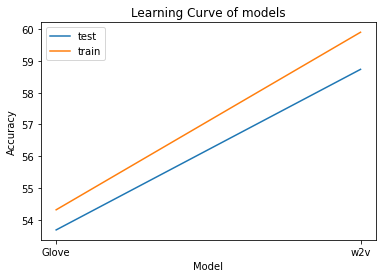

In [ ]:

plt.plot(["w2v","Glove"], test_results)
plt.plot(["w2v","Glove"], train_results)
plt.legend(['test', 'train'])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Learning Curve of models")
plt.show()

##Learning Curve
Υ.Γ αν στο tf-idf ειχα βαλει max_features=200 οπως στο count vectorizer θα εχει ακριβεια 60 οπως αυτο και το test στο learning curve θα ηταν γυρω στο 2% πιο πανω. απλα ηθελα να δειξω την επιρροη του ορισματος

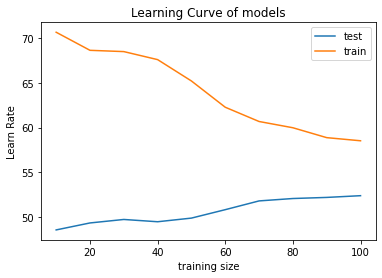

In [ ]:
plt.plot(range(10,110,10), test_learning_curve)
plt.plot(range(10,110,10), train_learning_curve)
plt.legend(['test', 'train'])
plt.xlabel("training size")
plt.ylabel("Learn Rate")
plt.title("Learning Curve of models")
plt.show()